#  Movie Insights Analysis
  
**Group Members:** Mathews Wandera, Tinah, Diana, Pacificah, Night, Frank  
**Branch Owners:**  
- `Mathews-Tableau`  
- `Tinah-Presentation`  
- `Diana-Data_Preparation`  
- `Pacificah-EDA`  
- `Night-Visualization`  
- `Frank-README`  

---

### Objective
To analyze multiple movie-related datasets from various platforms (IMDb, Rotten Tomatoes, The Numbers, TMDb, and Box Office Mojo) and provide strategic insights to support decision-making in the film industry.

# 1. Business Understanding

### Problem Statement
The movie industry produces a vast number of films every year, but only a few turn out to be box office hits or critical successes. Stakeholders—such as producers, distributors, and marketing teams—require data-driven insights to inform their decisions. By analyzing trends in budgets, genres, ratings, and revenues, we aim to uncover factors that contribute to a movie's commercial and critical success.

### Project Goal
This project seeks to:
- Identify the key characteristics of successful movies.
- Understand how different platforms rate movies (IMDb, Rotten Tomatoes, etc.).
- Analyze financial patterns like budget vs. revenue.
- Provide data-driven recommendations for improving the profitability and impact of future productions.

### Key Questions
- What genres perform best in terms of revenue and ratings?
- How do production budgets relate to revenue or critical scores?
- Are there specific patterns in release dates that impact success?
- What are the most profitable platforms or combinations of features?

### Target Audience
- Film producers and investors
- Distribution and marketing teams
- Data-driven creative teams in media
- Streaming platform analysts

# 2. Data Understanding
We'll now systematically explore each dataset to understand:

Structure (columns and data types)

- Sample data (via .head())

- Missing values

- Duplicates

- Basic statistics (via .describe())

We'll do this for:

**bom.movie_gross.csv.gz**

**rt.movie_info.tsv.gz**

**rt.reviews.tsv.gz**

**tmdb.movies.csv.gz**

**tn.movie_budgets.csv.gz**

Key tables from `im.db`: movie_basics, movie_ratings, principals, etc.



In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import zipfile
import os
from scipy.stats import f_oneway
from scipy.stats import ttest_ind

## Confirm available files

In [3]:

# Confirm available files
print(" Contents of 'datasets':")
print(os.listdir('datasets'))

 Contents of 'datasets':
['.gitignore', '.gitkeep', 'bom.movie_gross.csv.gz', 'im.db.zip', 'master_movie_dataset.csv', 'rt.movie_info.tsv.gz', 'rt.reviews.tsv.gz', 'tmdb.movies.csv.gz', 'tn.movie_budgets.csv.gz']


## Load external CSV/TSV dataset

In [4]:
# Load external CSV/TSV datasets
bom = pd.read_csv("datasets/bom.movie_gross.csv.gz")
rt_info = pd.read_csv("datasets/rt.movie_info.tsv.gz", sep="\t")
rt_reviews = pd.read_csv("datasets/rt.reviews.tsv.gz", sep="\t", encoding="latin1")  # fixed encoding issue
tmdb = pd.read_csv("datasets/tmdb.movies.csv.gz")
tn_budgets = pd.read_csv("datasets/tn.movie_budgets.csv.gz")


## Unzip the im.db.zip

In [5]:
if not os.path.exists("datasets/im.db"):
    with zipfile.ZipFile("datasets/im.db.zip", 'r') as zip_ref:
        zip_ref.extractall("datasets")

In [6]:
#Connect to the SQLite database
conn = sqlite3.connect("datasets/im.db")

# Preview available tables
tables = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn)
print("\n Tables in im.db:")
print(tables)


 Tables in im.db:
            name
0   movie_basics
1      directors
2      known_for
3     movie_akas
4  movie_ratings
5        persons
6     principals
7        writers


# 3. Data Preparation

Now that we have successfully loaded all datasets and explored their structure, we'll proceed with data preparation. This involves:

- Merging key datasets into a master data table.
- Cleaning and standardizing fields.
- Saving the final cleaned dataset for EDA and Tableau use.


## Step 1 — Prepare Individual DataFrames

### 🔹 Step 1: Select and Rename Relevant Columns

We’ll simplify each dataset and rename columns for consistency before merging. This ensures our final dataset is clean and easy to work with.


In [7]:
# Check column names in Rotten Tomatoes info dataset
print(rt_info.columns.tolist())


['id', 'synopsis', 'rating', 'genre', 'director', 'writer', 'theater_date', 'dvd_date', 'currency', 'box_office', 'runtime', 'studio']


### 1: BOM (Box Office Mojo)

In [8]:
# BOM dataset (Box Office Mojo)
bom_clean = bom[['title', 'domestic_gross', 'foreign_gross', 'year']].copy()
bom_clean.rename(columns={'title': 'movie_title'}, inplace=True)


###  2.TN (The Numbers) Budgets

In [9]:
# TN Budgets dataset
tn_budgets_clean = tn_budgets[['movie', 'production_budget', 'worldwide_gross', 'release_date']].copy()
tn_budgets_clean.rename(columns={'movie': 'movie_title'}, inplace=True)


### 3: TMDb

In [10]:
# TMDb dataset
tmdb_clean = tmdb[['title', 'id', 'popularity', 'vote_average', 'vote_count']].copy()
tmdb_clean.rename(columns={'title': 'movie_title', 'id': 'tmdb_id'}, inplace=True)


### 4: Rotten Tomatoes (info)

In [11]:
# Rotten Tomatoes info dataset
rt_info_clean = rt_info[['genre', 'rating', 'studio', 'theater_date', 'runtime']].copy()

# No title column, so we cannot rename to movie_title here — will join later if possible


## Step 2 – Load Tables from the SQLite Database
We'll extract and preview the following key tables:

- movie_basics – core movie metadata

- movie_ratings – IMDb average rating + votes

- principals – cast/crew info

- optionally) names, crew, etc., if needed later



### 5: Connect to the SQLite DB and List Tables

In [12]:
# Connect to the SQLite database
conn = sqlite3.connect('datasets/im.db')

# Check available tables
tables_query = "SELECT name FROM sqlite_master WHERE type='table';"
pd.read_sql(tables_query, conn)


,name
0,movie_basics
1,directors
2,known_for
3,movie_akas
4,movie_ratings
5,persons
6,principals
7,writers


### 6: Load Key Tables into DataFrames

In [13]:
# Load movie_basics
movie_basics = pd.read_sql("SELECT * FROM movie_basics", conn)

# Load movie_ratings
movie_ratings = pd.read_sql("SELECT * FROM movie_ratings", conn)

# Load principals (optional for later joins with crew/names)
principals = pd.read_sql("SELECT * FROM principals", conn)


### 7: Merge IMDb tables

**We merge movie_basics and movie_ratings on movie_id.**

In [14]:
# Merge basics and ratings
imdb_movies = pd.merge(movie_basics, movie_ratings, how='left', on='movie_id')

# Preview merged IMDb data
imdb_movies.head()


,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77.0
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",7.2,43.0
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,6.9,4517.0
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",6.1,13.0
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy",6.5,119.0


## Merging the data
Let's proceed step by step to merge the cleaned datasets into one master DataFrame that we'll use for EDA and Tableau.
**Step-by-Step Plan**
- Ensure all individual datasets are cleaned and renamed

- Merge them progressively using movie_title as the key

- Handle duplicates and missing values

- Save final master dataset to the datasets/ folder

### Step 1: Clean and Rename Columns for Merging



In [15]:
# BOM dataset: drop unnecessary columns and rename for consistency
bom_clean = bom[['title', 'domestic_gross', 'foreign_gross', 'year']].copy()
bom_clean.rename(columns={'title': 'movie_title'}, inplace=True)
bom_clean.head()


,movie_title,domestic_gross,foreign_gross,year
0,Toy Story 3,415000000.0,652000000,2010
1,Alice in Wonderland (2010),334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,296000000.0,664300000,2010
3,Inception,292600000.0,535700000,2010
4,Shrek Forever After,238700000.0,513900000,2010


In [16]:
# The Numbers movie budget data
tn_budgets_clean = tn_budgets[['movie', 'production_budget', 'worldwide_gross', 'release_date']].copy()
tn_budgets_clean.rename(columns={'movie': 'movie_title'}, inplace=True)
tn_budgets_clean.head()


,movie_title,production_budget,worldwide_gross,release_date
0,Avatar,"$425,000,000","$2,776,345,279","Dec 18, 2009"
1,Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$1,045,663,875","May 20, 2011"
2,Dark Phoenix,"$350,000,000","$149,762,350","Jun 7, 2019"
3,Avengers: Age of Ultron,"$330,600,000","$1,403,013,963","May 1, 2015"
4,Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$1,316,721,747","Dec 15, 2017"


In [17]:
# TMDb: includes popularity, vote average, vote count
tmdb_clean = tmdb[['title', 'id', 'popularity', 'vote_average', 'vote_count']].copy()
tmdb_clean.rename(columns={'title': 'movie_title', 'id': 'tmdb_id'}, inplace=True)
tmdb_clean.head()


,movie_title,tmdb_id,popularity,vote_average,vote_count
0,Harry Potter and the Deathly Hallows: Part 1,12444,33.533,7.7,10788
1,How to Train Your Dragon,10191,28.734,7.7,7610
2,Iron Man 2,10138,28.515,6.8,12368
3,Toy Story,862,28.005,7.9,10174
4,Inception,27205,27.920,8.3,22186


In [18]:
# Rotten Tomatoes info data
rt_info_clean = rt_info[['rating', 'genre', 'studio', 'theater_date', 'runtime']].copy()
rt_info_clean['movie_title'] = rt_info.index
rt_info_clean.reset_index(drop=True, inplace=True)
rt_info_clean.head()


,rating,genre,studio,theater_date,runtime,movie_title
0,R,Action and Adventure|Classics|Drama,NaN,"Oct 9, 1971",104 minutes,0
1,R,Drama|Science Fiction and Fantasy,Entertainment One,"Aug 17, 2012",108 minutes,1
2,R,Drama|Musical and Performing Arts,NaN,"Sep 13, 1996",116 minutes,2
3,R,Drama|Mystery and Suspense,NaN,"Dec 9, 1994",128 minutes,3
4,NR,Drama|Romance,NaN,NaN,200 minutes,4


## Step 2: Merging All Cleaned Datasets
Let’s now proceed cell by cell to merge them using movie_title as the key.

### Cell 1: Merge BOM + The Numbers Budgets

In [19]:
# Merge BOM and TN Budgets
bom_tn_merged = pd.merge(bom_clean, tn_budgets_clean, on='movie_title', how='outer')
bom_tn_merged.head()


,movie_title,domestic_gross,foreign_gross,year,production_budget,worldwide_gross,release_date
0,Toy Story 3,415000000.0,652000000,2010.0,"$200,000,000","$1,068,879,522","Jun 18, 2010"
1,Alice in Wonderland (2010),334200000.0,691300000,2010.0,NaN,NaN,NaN
2,Harry Potter and the Deathly Hallows Part 1,296000000.0,664300000,2010.0,NaN,NaN,NaN
3,Inception,292600000.0,535700000,2010.0,"$160,000,000","$835,524,642","Jul 16, 2010"
4,Shrek Forever After,238700000.0,513900000,2010.0,"$165,000,000","$756,244,673","May 21, 2010"


### Cell 2: Add TMDb Data

In [20]:
# Merge with TMDb data
bom_tn_tmdb = pd.merge(bom_tn_merged, tmdb_clean, on='movie_title', how='outer')
bom_tn_tmdb.head()


,movie_title,domestic_gross,foreign_gross,year,production_budget,worldwide_gross,release_date,tmdb_id,popularity,vote_average,vote_count
0,Toy Story 3,415000000.0,652000000,2010.0,"$200,000,000","$1,068,879,522","Jun 18, 2010",10193.0,24.445,7.7,8340.0
1,Alice in Wonderland (2010),334200000.0,691300000,2010.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Harry Potter and the Deathly Hallows Part 1,296000000.0,664300000,2010.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Inception,292600000.0,535700000,2010.0,"$160,000,000","$835,524,642","Jul 16, 2010",27205.0,27.920,8.3,22186.0
4,Shrek Forever After,238700000.0,513900000,2010.0,"$165,000,000","$756,244,673","May 21, 2010",10192.0,15.041,6.1,3843.0


### Cell 3: Add Rotten Tomatoes Info

In [21]:
# Ensure movie_title is a string before merge
rt_info_clean['movie_title'] = rt_info_clean['movie_title'].astype(str)
bom_tn_tmdb['movie_title'] = bom_tn_tmdb['movie_title'].astype(str)

# Now merge
master_df = pd.merge(bom_tn_tmdb, rt_info_clean, on='movie_title', how='outer')
master_df.head()


,movie_title,domestic_gross,foreign_gross,year,production_budget,worldwide_gross,release_date,tmdb_id,popularity,vote_average,vote_count,rating,genre,studio,theater_date,runtime
0,Toy Story 3,415000000.0,652000000,2010.0,"$200,000,000","$1,068,879,522","Jun 18, 2010",10193.0,24.445,7.7,8340.0,NaN,NaN,NaN,NaN,NaN
1,Alice in Wonderland (2010),334200000.0,691300000,2010.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Harry Potter and the Deathly Hallows Part 1,296000000.0,664300000,2010.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Inception,292600000.0,535700000,2010.0,"$160,000,000","$835,524,642","Jul 16, 2010",27205.0,27.920,8.3,22186.0,NaN,NaN,NaN,NaN,NaN
4,Shrek Forever After,238700000.0,513900000,2010.0,"$165,000,000","$756,244,673","May 21, 2010",10192.0,15.041,6.1,3843.0,NaN,NaN,NaN,NaN,NaN


## Step 3: Basic Cleaning

### Cell 4: Remove Duplicates, Check Nulls



In [22]:
# Remove duplicate movie entries
master_df.drop_duplicates(subset='movie_title', inplace=True)

# Display columns with missing values
master_df.isnull().sum().sort_values(ascending=False)


studio               30520
theater_date         29813
runtime              29484
genre                29462
rating               29457
foreign_gross        28977
domestic_gross       27656
year                 27628
release_date         25316
worldwide_gross      25316
production_budget    25316
vote_count            6326
vote_average          6326
popularity            6326
tmdb_id               6326
movie_title              0
dtype: int64

### As of now, we haven't merged any data from the SQLite database (im.db) yet.
We’ve only merged:

- bom.movie_gross.csv.gz → bom_clean

- tn.movie_budgets.csv.gz → tn_budgets_clean

- tmdb.movies.csv.gz → tmdb_clean

- rt.movie_info.tsv.gz → rt_info_clean


### Let's Now Include Data from the im.db Database Before Saving
- We'll extract and merge the most relevant tables:

- movie_basics — contains primary movie info (primary_title, genres, runtime_minutes)

- movie_ratings — contains average_rating, num_votes

- principals or others — optional (for deeper analysis)

### Cell 5A: Connect to the SQLite DB and Load Key Tables



In [23]:
# Connect to the SQLite database
conn = sqlite3.connect('datasets/im.db')

# Load main tables
movie_basics = pd.read_sql("SELECT * FROM movie_basics", conn)
movie_ratings = pd.read_sql("SELECT * FROM movie_ratings", conn)


### Cell 5B: Clean and Prepare the DB Tables for Merging

In [24]:
# Prepare movie_basics
basics_clean = movie_basics[['primary_title', 'genres', 'runtime_minutes']].copy()
basics_clean.rename(columns={'primary_title': 'movie_title'}, inplace=True)

# Prepare movie_ratings
ratings_clean = movie_ratings[['averagerating', 'numvotes']].copy()
ratings_clean.columns = ['imdb_rating', 'imdb_num_votes']

# Since ratings has same index as basics, we combine them first
imdb_combined = pd.concat([basics_clean, ratings_clean], axis=1)
imdb_combined.head()


,movie_title,genres,runtime_minutes,imdb_rating,imdb_num_votes
0,Sunghursh,"Action,Crime,Drama",175.0,8.3,31.0
1,One Day Before the Rainy Season,"Biography,Drama",114.0,8.9,559.0
2,The Other Side of the Wind,Drama,122.0,6.4,20.0
3,Sabse Bada Sukh,"Comedy,Drama",NaN,4.2,50352.0
4,The Wandering Soap Opera,"Comedy,Drama,Fantasy",80.0,6.5,21.0


## Cell 5C: Merge with Existing Master Dataset

In [25]:
# Merge IMDb info using outer join on movie_title
master_df = pd.merge(master_df, imdb_combined, on='movie_title', how='outer')
master_df.head()


,movie_title,domestic_gross,foreign_gross,year,production_budget,worldwide_gross,release_date,tmdb_id,popularity,vote_average,vote_count,rating,genre,studio,theater_date,runtime,genres,runtime_minutes,imdb_rating,imdb_num_votes
0,Toy Story 3,415000000.0,652000000,2010.0,"$200,000,000","$1,068,879,522","Jun 18, 2010",10193.0,24.445,7.7,8340.0,NaN,NaN,NaN,NaN,NaN,"Adventure,Animation,Comedy",103.0,6.1,160.0
1,Alice in Wonderland (2010),334200000.0,691300000,2010.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Harry Potter and the Deathly Hallows Part 1,296000000.0,664300000,2010.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Inception,292600000.0,535700000,2010.0,"$160,000,000","$835,524,642","Jul 16, 2010",27205.0,27.920,8.3,22186.0,NaN,NaN,NaN,NaN,NaN,"Action,Adventure,Sci-Fi",148.0,8.6,7.0
4,Shrek Forever After,238700000.0,513900000,2010.0,"$165,000,000","$756,244,673","May 21, 2010",10192.0,15.041,6.1,3843.0,NaN,NaN,NaN,NaN,NaN,"Adventure,Animation,Comedy",93.0,5.2,22.0


### Cell 5D: Check for Nulls and Duplicates Again After Merge

In [26]:
# Drop duplicates if they came back
master_df.drop_duplicates(subset='movie_title', inplace=True)

# Check nulls again
master_df.isnull().sum().sort_values(ascending=False).head(10)


studio               150671
theater_date         149964
runtime              149635
genre                149613
rating               149608
foreign_gross        149128
domestic_gross       147807
year                 147779
production_budget    145467
release_date         145467
dtype: int64

## Save the Master Dataset to CSV
Let’s save your final dataset to the datasets folder:

In [27]:
# Save the final master dataset to CSV
master_df.to_csv('datasets/master_movie_dataset.csv', index=False)


# 4. EXPLORATORY DATA ANALYSIS

In this section we aim to understand the overall structure of the `master_movie_dataset.csv` by examining the dataset and  summarizing its main characteristics using statistics and visualizations.

**Steps to achieve this:**

- Understand the structure and content of the data

- Identify missing or inconsistent values

- Detect outliers and anomalies

- Explore relationships between features

- Generate insights that can guide further analysis or modeling

We will examine a merged dataset containing movie information from multiple sources such as IMDb, Rotten Tomatoes,The Numbers,Box Office Mojo and TMDB.

### Step 1: Load the Master Dataset

In [29]:
# Load the dataset
df = pd.read_csv('datasets/master_movie_dataset.csv')

# Display the shape and first few rows
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (151165, 20)


C:\Users\helle\anaconda3\envs\learn-env\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (2,4,5,6,11,12,13,14,15) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,movie_title,domestic_gross,foreign_gross,year,production_budget,worldwide_gross,release_date,tmdb_id,popularity,vote_average,vote_count,rating,genre,studio,theater_date,runtime,genres,runtime_minutes,imdb_rating,imdb_num_votes
0,Toy Story 3,415000000.0,652000000,2010.0,"$200,000,000","$1,068,879,522","Jun 18, 2010",10193.0,24.445,7.7,8340.0,NaN,NaN,NaN,NaN,NaN,"Adventure,Animation,Comedy",103.0,6.1,160.0
1,Alice in Wonderland (2010),334200000.0,691300000,2010.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Harry Potter and the Deathly Hallows Part 1,296000000.0,664300000,2010.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Inception,292600000.0,535700000,2010.0,"$160,000,000","$835,524,642","Jul 16, 2010",27205.0,27.920,8.3,22186.0,NaN,NaN,NaN,NaN,NaN,"Action,Adventure,Sci-Fi",148.0,8.6,7.0
4,Shrek Forever After,238700000.0,513900000,2010.0,"$165,000,000","$756,244,673","May 21, 2010",10192.0,15.041,6.1,3843.0,NaN,NaN,NaN,NaN,NaN,"Adventure,Animation,Comedy",93.0,5.2,22.0


### Step 2: Overview of Columns and Data types

This helps us understand which columns are numerical, categorical, and where missing values exist.

In [30]:
# Column names and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151165 entries, 0 to 151164
Data columns (total 20 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   movie_title        151165 non-null  object 
 1   domestic_gross     3358 non-null    float64
 2   foreign_gross      2037 non-null    object 
 3   year               3386 non-null    float64
 4   production_budget  5698 non-null    object 
 5   worldwide_gross    5698 non-null    object 
 6   release_date       5698 non-null    object 
 7   tmdb_id            24688 non-null   float64
 8   popularity         24688 non-null   float64
 9   vote_average       24688 non-null   float64
 10  vote_count         24688 non-null   float64
 11  rating             1557 non-null    object 
 12  genre              1552 non-null    object 
 13  studio             494 non-null     object 
 14  theater_date       1201 non-null    object 
 15  runtime            1530 non-null    object 
 16  ge

### Step 3: Summary Statistics

In [31]:
#summary statistics for numeric columns
df.describe()

,domestic_gross,year,tmdb_id,popularity,vote_average,vote_count,runtime_minutes,imdb_rating,imdb_num_votes
count,3.358000e+03,3386.000000,24688.000000,24688.000000,24688.000000,24688.000000,106598.000000,70310.000000,7.031000e+04
mean,2.875439e+07,2013.957177,292050.796662,3.008331,5.983052,173.939606,86.186289,6.335036,3.501494e+03
std,6.699064e+07,2.477955,154978.956063,4.200146,1.868211,896.784914,172.111139,1.474287,3.024801e+04
min,1.000000e+02,2010.000000,27.000000,0.600000,0.000000,1.000000,1.000000,1.000000,5.000000e+00
25%,1.200000e+05,2012.000000,150201.750000,0.600000,5.000000,1.000000,70.000000,5.500000,1.400000e+01
50%,1.400000e+06,2014.000000,303294.000000,1.310500,6.000000,5.000000,86.000000,6.500000,4.900000e+01
75%,2.790000e+07,2016.000000,419055.000000,3.412000,7.000000,25.000000,99.000000,7.400000,2.830000e+02
max,9.367000e+08,2018.000000,608444.000000,80.773000,10.000000,22186.000000,51420.000000,10.000000,1.841066e+06


### Step 4: Check for missing Data

In [32]:
# Count of missing values per column
missing_values = df.isnull().sum().sort_values(ascending=False)

# Show only columns with missing data
missing_values[missing_values > 0]

studio               150671
theater_date         149964
runtime              149635
genre                149613
rating               149608
foreign_gross        149128
domestic_gross       147807
year                 147779
production_budget    145467
release_date         145467
worldwide_gross      145467
vote_average         126477
vote_count           126477
popularity           126477
tmdb_id              126477
imdb_num_votes        80855
imdb_rating           80855
runtime_minutes       44567
genres                19985
dtype: int64

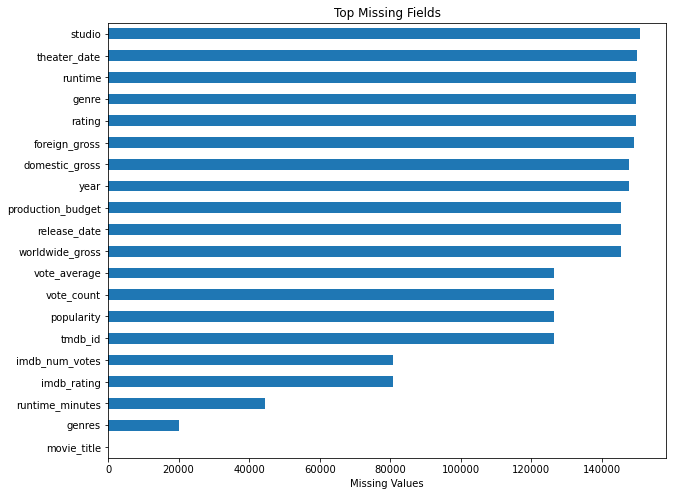

In [33]:
# visualize the missing data

# Plot top 20 columns with missing values
missing_values.head(20).plot(kind='barh', figsize=(10, 8), title='Top Missing Fields')
plt.gca().invert_yaxis()
plt.xlabel('Missing Values')
plt.show()

#### Interpretation

The top 10 columns (like studio, theater_date, runtime, genre, etc.) each have over 140,000 missing values, indicating that a significant portion of the dataset lacks this information.

Columns such as:studio,theater_date,runtime,genre and rating are severely incomplete, likely because many entries came from sources that didn’t provide these details (e.g., IMDb might not list theater release dates for all entries).

Mid-level missingness is observed in:vote_count, vote_average, popularity, and tmdb_id
These are primarily from TMDb, so their absence suggests the TMDb data didn’t cover all films in the master set.

The least missing columns:genres, runtime_minutes, imdb_rating, and imdb_num_votes
These were likely better covered by the IMDb data and cleaned properly.

movie_title has zero missing values, which is expected and important, since it's the key used for merging datasets.

### Step 5: Clean financial columns

Some monetary values are stored as strings with $ and commas. Let's clean those.

In [35]:
# Clean dollar-formatted columns
def clean_money(series):
    return series.replace('[\$,]', '', regex=True).astype(float)

money_cols = ['production_budget', 'worldwide_gross', 'domestic_gross', 'foreign_gross']
for col in money_cols:
    df[col] = clean_money(df[col])

### Step 6: Drop Duplicates and Confirm

In [36]:
# Drop duplicates based on movie_title
df.drop_duplicates(subset='movie_title', inplace=True)

# Confirm shape
print("Shape after removing duplicates:", df.shape)

Shape after removing duplicates: (151165, 20)


### Step 7: Correlation Heatmap
Let’s check how numerical features relate to each other

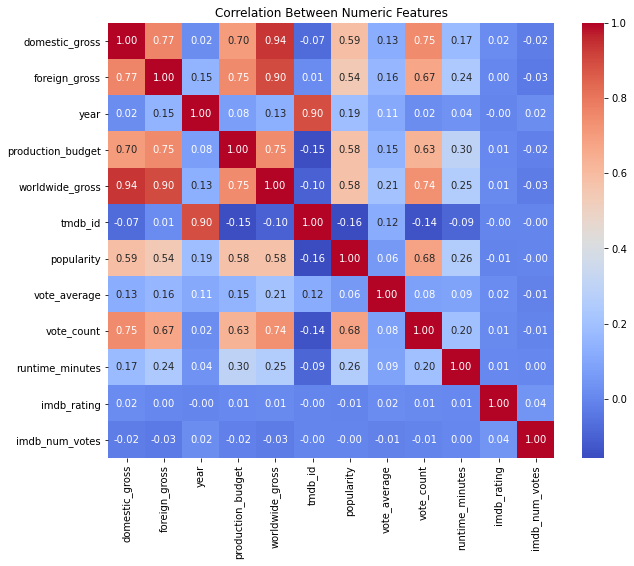

In [38]:
# Select only numeric columns for correlation
numeric_df = df.select_dtypes(include='number')

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Between Numeric Features')
plt.show()

### Correlation Heatmap Interpretation
This heatmap visualizes the correlation between various numeric features in the movie dataset. Key findings include:

#### Revenue Relationships
Domestic Gross & Worldwide Gross: Very strong correlation (0.94), indicating domestic revenue heavily contributes to global earnings.

Foreign Gross & Worldwide Gross: Also strongly correlated (0.90), meaning both domestic and foreign markets are crucial for total revenue.

Production Budget is moderately correlated with both:

Domestic Gross: 0.70

Worldwide Gross: 0.75
Suggesting higher budgets often lead to higher returns, but not always proportionally.

#### Popularity and Voting Patterns
Popularity correlates:

Strongly with Vote Count (0.68)

Moderately with Domestic/Foreign Gross and Worldwide Gross (~0.58-0.60)
This implies that popular films tend to earn more and receive more audience engagement.

Vote Count is also correlated with:

Worldwide Gross (0.74)

Production Budget (0.63)

Domestic Gross (0.75)
Suggesting that commercially successful movies receive more votes.

#### IMDb Ratings
Surprisingly, IMDb Rating has very weak correlations with:

Gross Revenue (all < 0.10)

Vote Count and Popularity
This suggests audience ratings are relatively independent of commercial success.

#### Other Observations
Runtime has weak to moderate positive correlations with:

Vote Count (0.20)

Production Budget (0.30)
But minimal correlation with revenues or ratings.

TMDb ID and Year show no meaningful correlations and likely serve as identifiers or time markers rather than predictors.

# Summary

At this point, we’ve:

- Loaded and explored the dataset

- Identified and visualized missing data

- Cleaned financial fields

- Removed duplicates

- Explored correlations

### Step 8: Visual Analysis by Genre

We'll explore how genres are distributed and which genres are most common in the dataset.

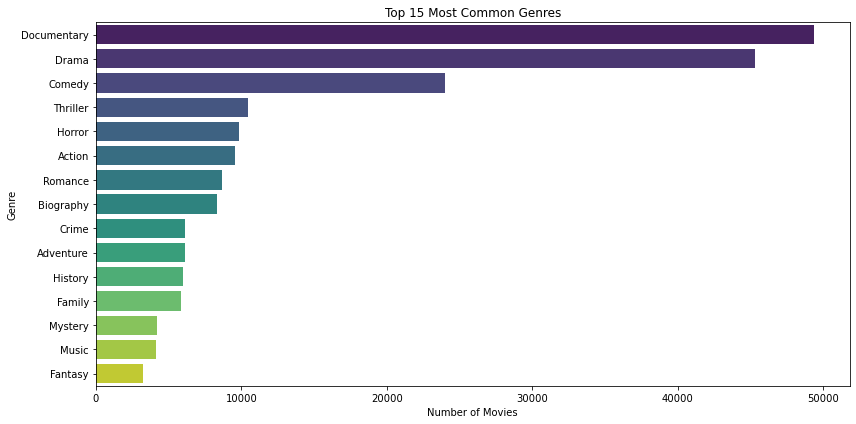

In [39]:
# Count the top 15 genres
top_genres = df['genres'].dropna().str.split(',').explode().value_counts().head(15)

# Plot the genre distribution
plt.figure(figsize=(12, 6))
sns.barplot(x=top_genres.values, y=top_genres.index, palette='viridis')
plt.title('Top 15 Most Common Genres')
plt.xlabel('Number of Movies')
plt.ylabel('Genre')
plt.tight_layout()
plt.show()

### Top 15 Most Common Movie Genres
This bar chart displays the 15 most frequently occurring movie genres in the dataset. The number of movies per genre is shown on the x-axis.

#### Key Observations:
- Documentary is the most common genre, with nearly 50,000 movies, indicating high production volume, possibly due to lower budget requirements and educational demand.

- Drama follows closely, with over 40,000 entries, suggesting it’s a highly favored storytelling format in film production.

- Comedy ranks third, with more than 20,000 movies, reflecting its broad audience appeal.

- Thriller, Horror, Action, and Romance form a mid-tier group with between 8,000–12,000 movies each, showing consistent but slightly lower popularity.

- Genres like Biography, Crime, Adventure, and History have moderate representation, ranging between 5,000–8,000 movies.

- Family, Mystery, Music, and Fantasy are the least represented among the top 15 but still significant, each with several thousand entries.

#### Implications:
- Content creators and studios may prioritize genres like Drama, Comedy, and Documentary due to high audience interest or lower production barriers.

- Niche genres such as Music and Fantasy, while less common, may offer unique storytelling opportunities and face less competition.

### Step 9: Studio Output

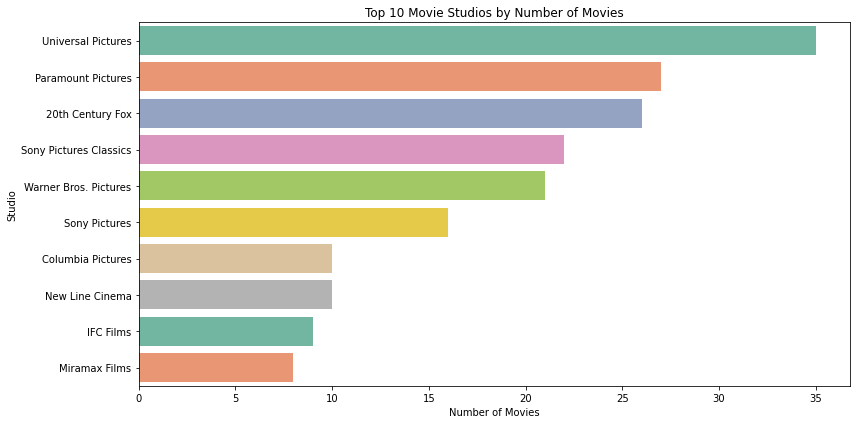

In [40]:
top_studios = df['studio'].value_counts().head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_studios.values, y=top_studios.index, palette='Set2')
plt.title('Top 10 Movie Studios by Number of Movies')
plt.xlabel('Number of Movies')
plt.ylabel('Studio')
plt.tight_layout()
plt.show()

### Top 10 Movie Studios by Number of Movies
This bar chart showcases the 10 studios with the highest number of movies in the dataset. It provides insight into studio-level production volume.

#### Key Observations:
- Universal Pictures leads with 35+ movies, making it the most prolific studio in this dataset.

- Paramount Pictures and 20th Century Fox follow closely, each producing over 25 movies, highlighting their longstanding industry presence.

- Sony Pictures Classics, Warner Bros. Pictures, and Sony Pictures also show strong representation, each contributing 15–22 movies.

- Columbia Pictures and New Line Cinema are in the 10–12 movie range, reflecting moderate but notable output.

- IFC Films and Miramax Films, known for more independent or niche content, round out the top 10 with under 10 movies each.

#### Implications:
- Major studios like Universal, Paramount, and Fox dominate the dataset, aligning with their market influence and financial resources.

- A diverse mix of traditional studios and indie-oriented labels (e.g., IFC, Miramax) signals varied content types and target audiences.

- Analyzing production volume alongside revenue or ratings could help identify efficiency or quality leaders

### Step 10: Trend by Release Year

We'll analyze how many movies are released each year.

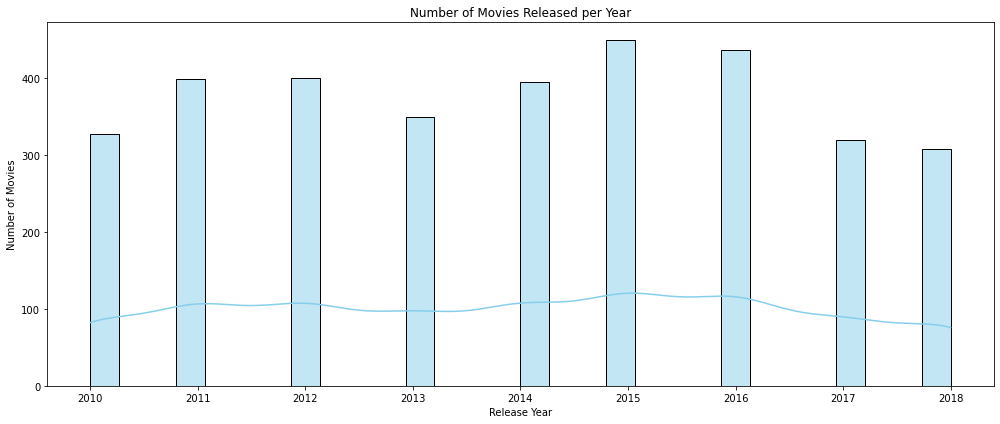

In [41]:
# Drop NA in 'year' and convert to int
df_year = df['year'].dropna().astype(int)

plt.figure(figsize=(14, 6))
sns.histplot(df_year, bins=30, kde=True, color='skyblue')
plt.title('Number of Movies Released per Year')
plt.xlabel('Release Year')
plt.ylabel('Number of Movies')
plt.tight_layout()
plt.show()

### Interpretation of Movies Released per Year (2010–2018)
The bar chart above visualizes the number of movies released each year from 2010 to 2018. The bars represent yearly movie counts, while a smooth line trend overlays the chart, providing insight into the general movement over time.

#### Key Observations:
Growth Period (2010–2015):

- The number of movies increased steadily from around 330 in 2010 to a peak of over 450 in 2015.

- This suggests a consistent rise in movie production over these years.

Peak Years:

- 2015 had the highest number of movie releases, followed closely by 2016.

- Both years exceeded 430 movies, indicating a production boom.

Decline Period (2016–2018):

- There is a noticeable decline after 2016, with the number dropping to just over 300 by 2018.

- This could imply industry saturation, shifting production strategies, or external influences.

Trend Line Insight:

- The light blue line confirms the initial upward trend and the subsequent decline, reinforcing the observations seen in the bars.

#### Summary:

From 2010 to 2015, the film industry experienced a significant increase in output. However, starting in 2016, there was a downward trend in movie releases, with 2018 having one of the lowest counts in the timeframe. This chart effectively captures both the peak and the slowdown of annual movie production over the 9-year period.

### Step 11: Popularity vs Ratings

How does TMDb popularity relate to audience scores? 

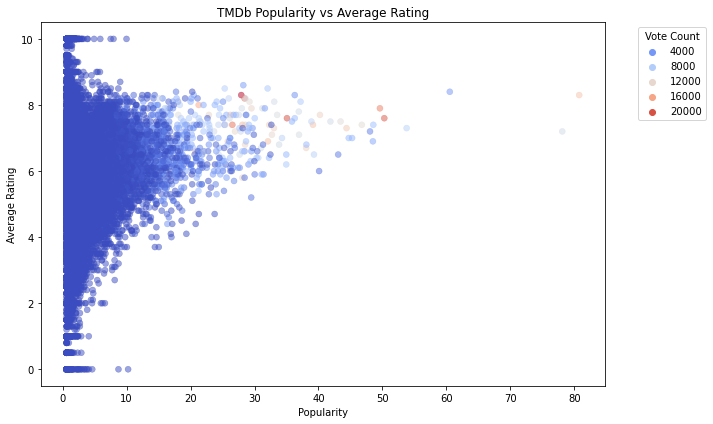

In [44]:
# Popularity vs Ratings

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='popularity',
    y='vote_average',
    data=df,
    alpha=0.5,
    hue='vote_count',
    palette='coolwarm',
    edgecolor=None
)
plt.title('TMDb Popularity vs Average Rating')
plt.xlabel('Popularity')
plt.ylabel('Average Rating')
plt.legend(title='Vote Count', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## TMDb Popularity vs Average Rating
This scatter plot illustrates the relationship between movie popularity (based on TMDb metrics) and their average viewer ratings, with the color and size of each point representing the vote count.

#### Key Insights:
Concentration of Data:

- The majority of movies are clustered in the low popularity range (0–20) and have an average rating between 5 and 8.

- These movies also tend to have lower vote counts, shown by the denser dark blue markers.

Popularity vs Rating:

- There's no strong linear correlation between popularity and average rating.

- Some less popular movies have very high ratings, and vice versa.

High Vote Count Movies:

- A few movies with high popularity (40+) and high vote counts (lighter to red hues) generally maintain good ratings (around 7–- 8).

These are likely mainstream or blockbuster films.

Outliers:

- Several outliers appear with very low ratings (below 2) or very high ratings (above 9) but are not necessarily popular or widely voted on.

These may represent niche or critically polarizing titles.

### Summary:
While the scatter plot shows a dense concentration of average-rated, low-popularity movies, there are notable exceptions that combine high popularity, strong ratings, and high vote counts. Overall, popularity does not guarantee high ratings, but popular movies tend to be rated more frequently.

## Step 12: Hypothesis Testing

**Objective**
Test whether average IMDb ratings are significantly different across selected genres.

- **Null Hypothesis (H₀):** Mean IMDb ratings are the same across all genres.

- **Alternative Hypothesis (H₁):** At least one genre has a different mean IMDb rating.

In [47]:
# Select relevant genres
genres_to_test = ['Action', 'Comedy', 'Drama', 'Horror', 'Romance']

# Prepare groups: list of imdb_rating Series per genre
rating_groups = []

for genre in genres_to_test:
    group = df[df['genres'].str.contains(genre, na=False)]['imdb_rating'].dropna()
    rating_groups.append(group)

# Run ANOVA
f_stat, p_val = f_oneway(*rating_groups)

print("Genres tested:", genres_to_test)
print(f"F-statistic: {f_stat:.2f}")
print(f"P-value: {p_val:.4f}")

Genres tested: ['Action', 'Comedy', 'Drama', 'Horror', 'Romance']
F-statistic: 0.86
P-value: 0.4881


#### Interpretation
Since the p-value (0.4881) > 0.05, **we fail to reject the null hypothesis.**

This means there's no statistically significant difference in average IMDb ratings between the genres tested.

In simpler terms:

**Based on the data we analyzed, Action, Comedy, Drama, Horror, and Romance movies have similar average IMDb ratings, statistically speaking.**

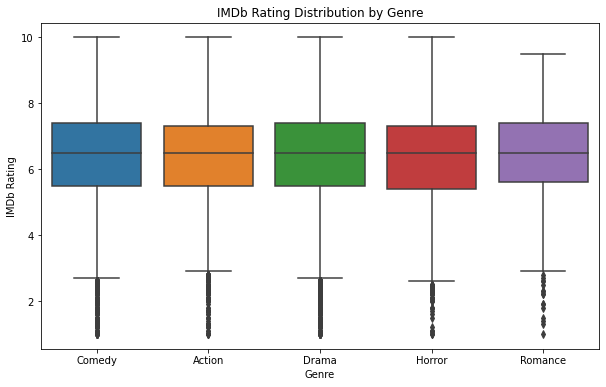

In [48]:
#Visual Support
#Add a boxplot to visualize rating distributions by genre:
# Filter and explode genres for plotting
df_genres = df[df['genres'].notna()].copy()
df_genres['primary_genre'] = df_genres['genres'].str.extract(f"({'|'.join(genres_to_test)})")

# Plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_genres[df_genres['primary_genre'].notna()],
            x='primary_genre', y='imdb_rating')
plt.title('IMDb Rating Distribution by Genre')
plt.xlabel('Genre')
plt.ylabel('IMDb Rating')
plt.show()

## IMDb Rating Distribution by Genre
The boxplot above visualizes the distribution of IMDb ratings across five different movie genres: Comedy, Action, Drama, Horror, and Romance.

### Key Observations:
**Overall Rating Range:**

- Ratings across all genres range from about 1 to 10.

- A number of outliers (shown as dots) exist at the lower end of the rating scale in every genre.

**Median Ratings:**

- The median rating (middle line in each box) is quite similar across genres, mostly falling between 6 and 7.

- This suggests a relatively consistent central rating tendency across different movie genres.

**Interquartile Range (IQR):**

- The height of each box shows the IQR (middle 50% of ratings), which is also similar across genres, roughly from 5.5 to 7.5.

- Drama and Romance genres exhibit a slightly wider spread than Comedy and Horror.

**Outliers:**

- All genres display a significant number of low-rating outliers (below 4), indicating that some movies received notably poor audience reception.

- Romance and Horror appear to have the highest number of low-rating outliers.

**Symmetry and Skewness:**

The distributions are fairly symmetric, but some genres like Horror show slight negative skew, implying a few higher-rated films might be pulling the average up.

### Summary:
The IMDb rating distribution is largely consistent across genres, with most movies scoring between 5.5 and 7.5. However, genres like Horror and Romance tend to have more low-rated outliers, which may suggest higher variance in audience reception.

## Step 13: Perform Independent Samples t-test

We'll compare the IMDb ratings for movies in the "Action" and "Drama" genres.

In [50]:
# Filter dataset by genres
action_ratings = df[df['genres'].str.contains('Action', na=False)]['imdb_rating'].dropna()
drama_ratings = df[df['genres'].str.contains('Drama', na=False)]['imdb_rating'].dropna()

# Perform t-test
t_stat, p_value = ttest_ind(action_ratings, drama_ratings, equal_var=False)

print(f"T-statistic: {t_stat:.2f}")
print(f"P-value: {p_value:.4f}")

T-statistic: -0.37
P-value: 0.7089


### Interpretation
**P-value > 0.05**
→ This means the difference in average IMDb ratings between Action and Drama movies is not statistically significant.

**T-statistic ≈ 0**
→ Suggests the difference between the group means is very small.

### Conclusion:
There is no strong evidence to suggest that Action and Drama movies differ in their average IMDb ratings based on your dataset. Any difference you see is likely due to random variation rather than a real underlying difference.

## 

### 5. Visualization.